#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [3]:
file_name = "/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/train/file_brain_AXT1POST_200_6002124.h5"
hf = h5py.File(file_name)

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT1POST', 'max': 0.0011839073109150002, 'norm': 0.2291060314960097, 'patient_id': '824ccba3996110b81bd475dcdf0118d07f99772f06579eb34e5421d9216cd7ba'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [5]:
volume_kspace = hf['kspace'][()] # swap channels
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [6]:
##
volume_kspace = np.swapaxes(volume_kspace, 0,1)
##
slice_kspace = volume_kspace[15] # Choosing the 20-th slice of this volume
#slice_kspace = volume_kspace[:,19,:,:] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [7]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap) 
        #plt.imshow(data[:,num,:,:], cmap=cmap)  #####CHEEEEEEEEEEEECK!!!!!!!!!!!!!!!!!!!
        

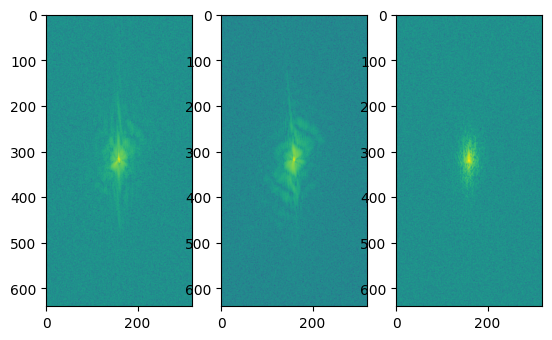

In [8]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 15])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [9]:
import fastmri
from tqdm.notebook import tqdm
from fastmri.data import transforms as T

/home/woody/iwbi/iwbi009h/software/privat/conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

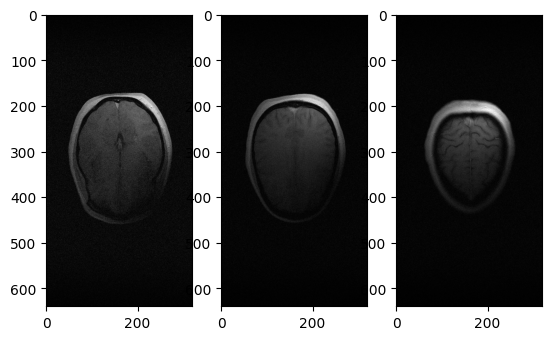

In [11]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [12]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

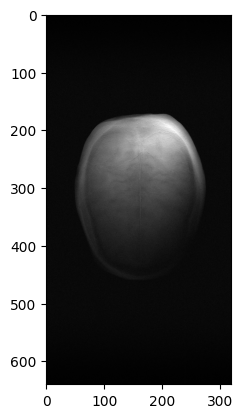

In [13]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [14]:
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFractionFunc, create_mask_for_mask_type
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [15]:
masked_kspace, mask, rq = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
print(masked_kspace.shape, mask.shape, rq)

torch.Size([16, 640, 320, 2]) torch.Size([1, 1, 320, 1]) 13


In [16]:
mask_type="equispaced_fraction"  # VarNet uses equispaced mask
center_fractions = [0.08 ]
accelerations = [4] 
mask = create_mask_for_mask_type(mask_type, center_fractions, accelerations)


Let's see what the subsampled image looks like:

In [17]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

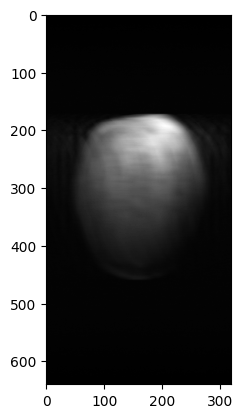

In [18]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

In [19]:
import torch
def apply_mask(data, 
               mask_type="equispaced_fraction",  # VarNet uses equispaced mask
               center_fractions = [0.08 ],
               accelerations = [4] ):
    
    mask_func = EquispacedMaskFractionFunc(center_fractions, accelerations)
    volume_kspace = data['kspace'][()] # swap channels ??
    volume_kspace = np.swapaxes(volume_kspace, 0,1) # uncomment if needed
    atbs = []
    masks = []
    for slice_kspace in volume_kspace:
        slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
        masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
        sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
        sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
        sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
        ## we need complex values -> real and imaginary parts are stored separately...
        # for i in range(sampled_image.shape[0]):
        #     sampled_image[i] = torch,complex(sampled_image[i])
        # sampled_image_rss = fastmri.rss(sampled_image, dim=0)
        sampled_image_rss = sampled_image_rss.numpy()
        #sampled_image_rss = np.abs(sampled_image_rss)
        atbs.append(sampled_image_rss)
        masks.append(mask.numpy())
    return np.asarray(atbs), np.asarray(masks)

In [20]:
atb, mask = apply_mask(hf)

In [21]:
print(mask.shape)
print(atb.shape)

(16, 1, 1, 320, 1)
(16, 640, 320)


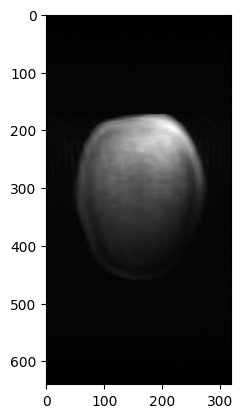

In [22]:
plt.imshow(atb[15], cmap='gray')

<KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
<HDF5 dataset "atb": shape (1, 640, 368), type "<c8">
<HDF5 dataset "org": shape (1, 640, 368), type "<c8">
<HDF5 dataset "mask": shape (1, 640, 368), type "<c8">


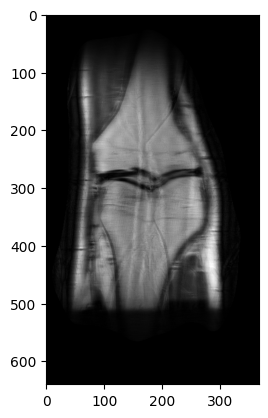

In [23]:
with h5py.File('/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/modl/knee_demo_data.h5','r') as f:
    print(f.keys())
    print(f['atb'])
    print(f['org'])
    print(f['mask'])
    plt.imshow(np.abs(f['atb'][-1]), cmap='gray')

In [24]:
#terminal: sinfo ->> GPUS available

In [25]:
#+sbatch sbatch_run.sh

In [26]:
#squeue